In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  return "Done"

set_seed(42)

'Done'

In [3]:
array = np.linspace(0, 119, 120)
print(array)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119.]


In [4]:
test_size = 20
train_set = array[:-test_size]
test_set = array[-test_size:]

In [5]:
print(train_set)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89.
 90. 91. 92. 93. 94. 95. 96. 97. 98. 99.]


In [6]:
print(test_set)

[100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113.
 114. 115. 116. 117. 118. 119.]


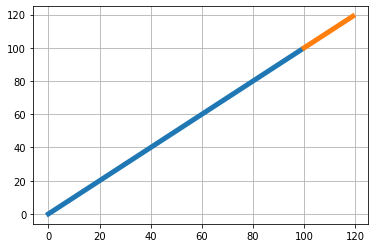

In [7]:
plt.plot(train_set, linewidth=5)
plt.grid(True)
plt.plot(test_set, range(100, 120), linewidth=5)

In [8]:
def input_data(data, ws):
  out = []

  for i in range(len(data)-ws):
    feature = data[i:i+ws+1]
    out.append(feature)

  df = pd.DataFrame(out)
  return df

In [9]:
input_data(train_set,3)

,0,1,2,3
0,0.0,1.0,2.0,3.0
1,1.0,2.0,3.0,4.0
2,2.0,3.0,4.0,5.0
3,3.0,4.0,5.0,6.0
4,4.0,5.0,6.0,7.0
...,...,...,...,...
92,92.0,93.0,94.0,95.0
93,93.0,94.0,95.0,96.0
94,94.0,95.0,96.0,97.0
95,95.0,96.0,97.0,98.0


In [10]:
class CustomDatasetTrain(Dataset):
  def __init__(self):
    self.df = input_data(train_set, 3)
    self.x = torch.from_numpy(self.df.drop(3,axis=1).to_numpy()).float()
    self.y = torch.from_numpy(self.df[3].to_numpy()).float()
    self.n_sample = self.df.shape[0]

  def __getitem__(self, index):
    return self.x[index], self.y[index]

  def __len__(self):
    return self.n_sample

train_data= CustomDatasetTrain()

In [11]:
class CustomDatasetTest(Dataset):
    def __init__(self):
        self.df = input_data(test_set,3)
        self.x = torch.from_numpy(self.df.drop(3,axis=1).to_numpy()).float()
        self.y = torch.from_numpy(self.df[3].to_numpy()).float()
        self.n_sample = self.df.shape[0]

    def __getitem__(self, index):
        return self.x[index],self.y[index]
    
    def __len__(self):
        return self.n_sample
    
test_data = CustomDatasetTest()

In [12]:
train_loader = DataLoader(train_data,4,True)
test_loader = DataLoader(test_data,4)

In [13]:
for data in train_loader:
    print(data[0].reshape(-1,3,1))
    break

tensor([[[85.],
         [86.],
         [87.]],

        [[38.],
         [39.],
         [40.]],

        [[53.],
         [54.],
         [55.]],

        [[22.],
         [23.],
         [24.]]])


# Model Train and Evaluation

In [14]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, linear_output, batch_size, bidirectional, batch_first):
    super().__init__()

    self.lstm = nn.LSTM(input_size=input_size, 
                      hidden_size=hidden_size,
                      num_layers=num_layers,
                      batch_first=batch_first,
                      bidirectional=bidirectional)
    self.linear = nn.Linear(hidden_size, 12)
    self.linear_1 = nn.Linear(12,1)

  def forward(self, input_data):
    input_ = input_data.reshape(-1, 3, 1)
    #print(input_)
    output, (hidden, cell) = self.lstm(input_)
    pred = self.linear(hidden)
    pred = self.linear_1(pred)
    
    return pred

In [15]:
batch_size = 5

train_loader = DataLoader(train_data, batch_size)
test_loader = DataLoader(test_data, batch_size)

model = LSTM(input_size=1,
            hidden_size=100,
            num_layers=2,
            linear_output = 1,
            batch_size= batch_size,
            bidirectional= False,
            batch_first= True)

loss_func = nn.MSELoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.1)



In [16]:
print(model)

LSTM(
  (lstm): LSTM(1, 100, num_layers=2, batch_first=True)
  (linear): Linear(in_features=100, out_features=12, bias=True)
  (linear_1): Linear(in_features=12, out_features=1, bias=True)
)


In [17]:
for i in model.parameters():
  print(i.shape)

torch.Size([400, 1])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])
torch.Size([400, 100])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])
torch.Size([12, 100])
torch.Size([12])
torch.Size([1, 12])
torch.Size([1])


In [24]:
epochs = 200
loss = 0
from tqdm import tqdm

for epoch in range(epochs):
  with tqdm(train_loader) as tqdm_epoch:
    for data, label in tqdm_epoch:
      tqdm_epoch.set_description(f"Epoch {epoch+1}/{epochs}")
      optimizer.zero_grad()
      #print(data)
      pred = model.forward(data)
      loss = loss_func(pred, label.reshape(1,-1,1))
      #print(f"pred: {pred} \n label:  {label}")
      loss.backward()

      optimizer.step()

      tqdm_epoch.set_postfix(loss=loss.item())


Epoch 1/200:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 5, 1])) that is different to the input size (torch.Size([2, 5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/200:  85%|████████▌ | 17/20 [00:00<00:00, 40.43it/s, loss=0.518]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 2, 1])) that is different to the input size (torch.Size([2, 2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 200/200: 100%|██████████| 20/20 [00:00<00:00, 72.69it/s, loss=0.00996]


In [25]:
model.eval()
loss = 0
batch = 0
original = []
predi = []
with torch.no_grad():
    for data, label in test_loader:
        pred = model.forward(data)
        original.extend(label.tolist())
        predi.extend(pred[0].reshape(1,-1).tolist())
        loss += loss_func(pred,label.reshape(1,-1,1))
        print(label,pred)
        batch+=1
        
    print(f"Loss : {loss/batch}")

tensor([103., 104., 105., 106., 107.]) tensor([[[101.6684],
         [102.2234],
         [102.7299],
         [103.1937],
         [103.6208]],

        [[101.3694],
         [101.8558],
         [102.2965],
         [102.6974],
         [103.0637]]])
tensor([108., 109., 110., 111., 112.]) tensor([[[104.0175],
         [104.3898],
         [104.7427],
         [105.0798],
         [105.4041]],

        [[103.4007],
         [103.7128],
         [104.0039],
         [104.2770],
         [104.5341]]])
tensor([113., 114., 115., 116., 117.]) tensor([[[105.7169],
         [106.0194],
         [106.3125],
         [106.5977],
         [106.8777]],

        [[104.7767],
         [105.0055],
         [105.2213],
         [105.4248],
         [105.6172]]])
tensor([118., 119.]) tensor([[[107.1564],
         [107.4385]],

        [[105.8000],
         [105.9752]]])
Loss : 67.31532287597656


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 5, 1])) that is different to the input size (torch.Size([2, 5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 2, 1])) that is different to the input size (torch.Size([2, 2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


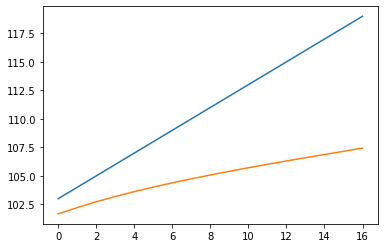

In [26]:
test = []
for i in predi:
    test.extend(i)

# test = [int(i) for i in test]
plt.plot(original)
plt.plot(test)